<a href="https://colab.research.google.com/github/surajjorwar/FitnessTracker/blob/main/Low_pass_Filter_%26_Principal_Component_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
%cd '/content/drive/MyDrive/FitnessTracker/FitnessTracker/data-science-template-main/src/features'


/content/drive/MyDrive/FitnessTracker/FitnessTracker/data-science-template-main/src/features


In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter,PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from FrequencyAbstraction import FourierTransformation
from sklearn.cluster import KMeans


# Load data

In [91]:
df= pd.read_pickle('/content/drive/MyDrive/FitnessTracker/FitnessTracker/data-science-template-main/data/interim/02_outliers_removed_chauvenets.pkl')

In [92]:
predictor_columns = list(df.iloc[:,:6])

In [93]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"]= (20,5)
plt.rcParams["figure.dpi"]= 100
plt.rcParams["lines.linewidth"] = 2

# Dealing with missing values (imputation)


In [94]:
for col in predictor_columns:
  df[col] = df[col].interpolate()

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB


# Calculating set duration

<Axes: xlabel='epoch (ms)'>

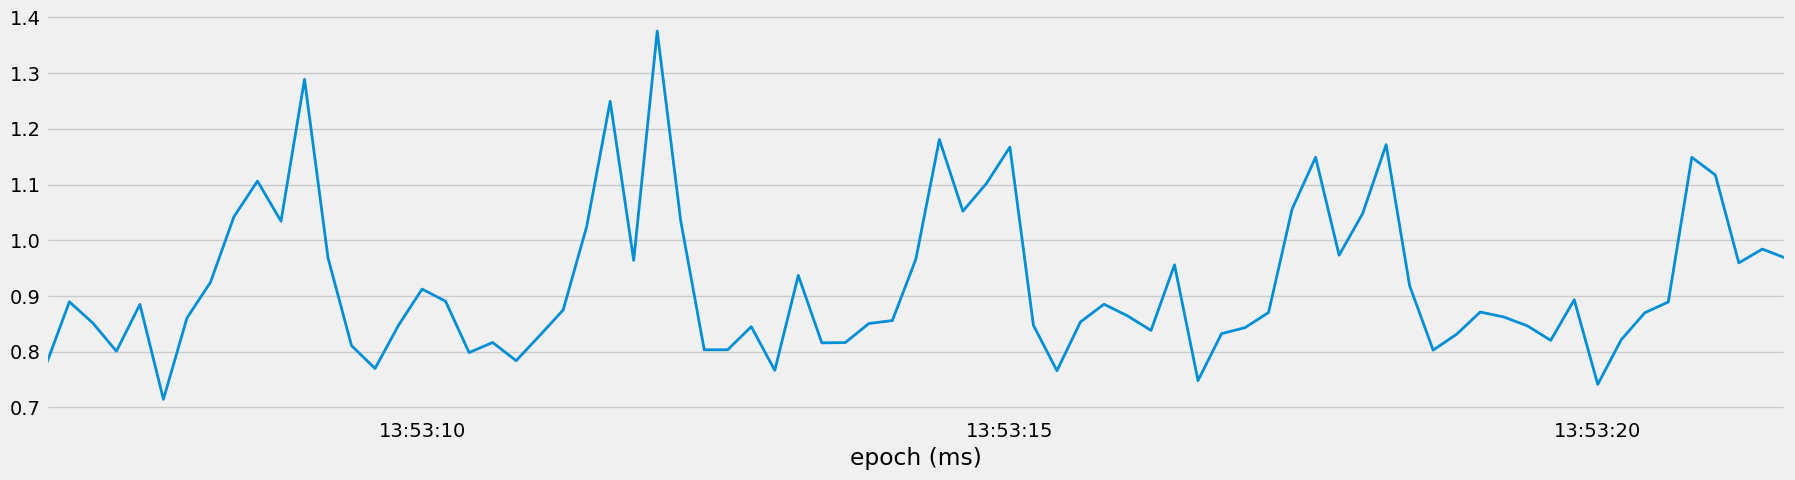

In [96]:
df[df['set']==22]["acc_y"].plot()

<Axes: xlabel='epoch (ms)'>

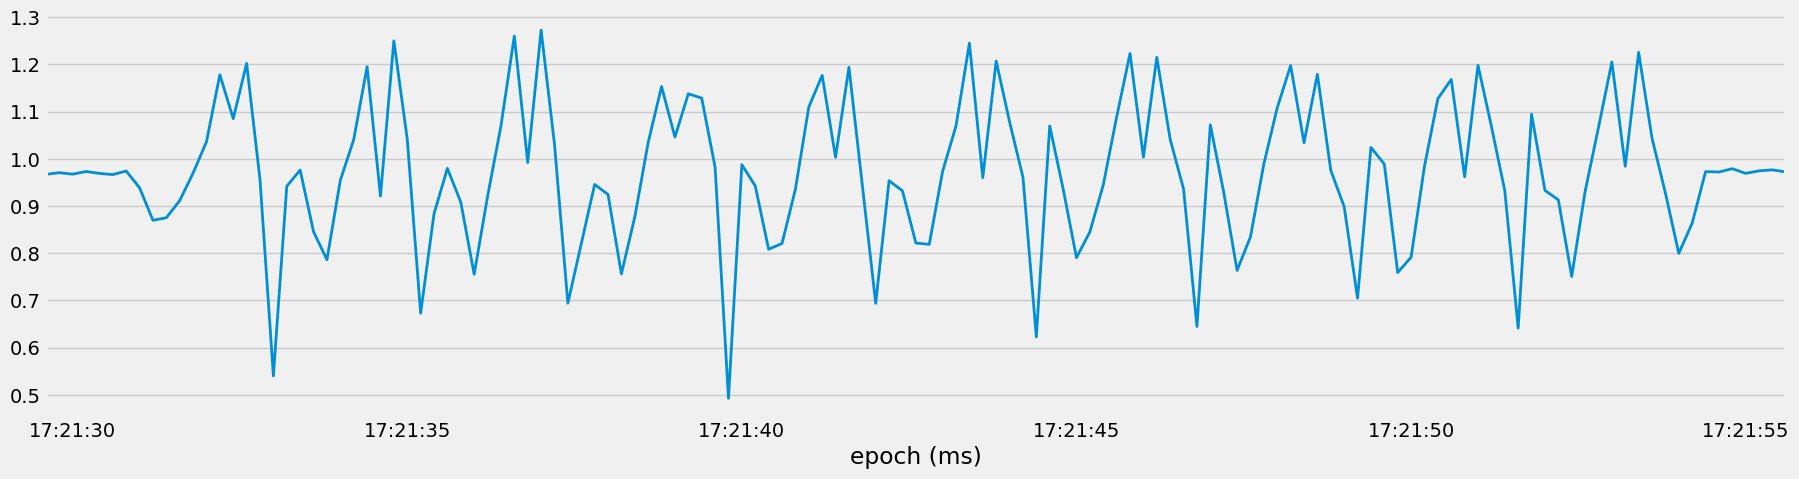

In [97]:
df[df['set']==50]["acc_y"].plot()

# Calculating set duration

In [98]:
for s in df['set'].unique():
  start = df[df['set']==s].index[0]
  stop = df[df['set']==s].index[-1]
  duration =   stop -start
  df.loc[(df['set']==s),"duration"] = duration.seconds

In [99]:
df.groupby(['category'])['duration'].mean()

category
heavy       14.743501
medium      24.942529
sitting     33.000000
standing    39.000000
Name: duration, dtype: float64

In [100]:
duration_df = df.groupby(['category'])['duration'].mean()

In [101]:
print('heavy',duration_df.iloc[0]/5)
print('medium',duration_df.iloc[1]/10 )

heavy 2.9487001733102254
medium 2.4942528735632186


# Butterworth lowpass filter

In [102]:
df_lowpass = df.copy()

dead


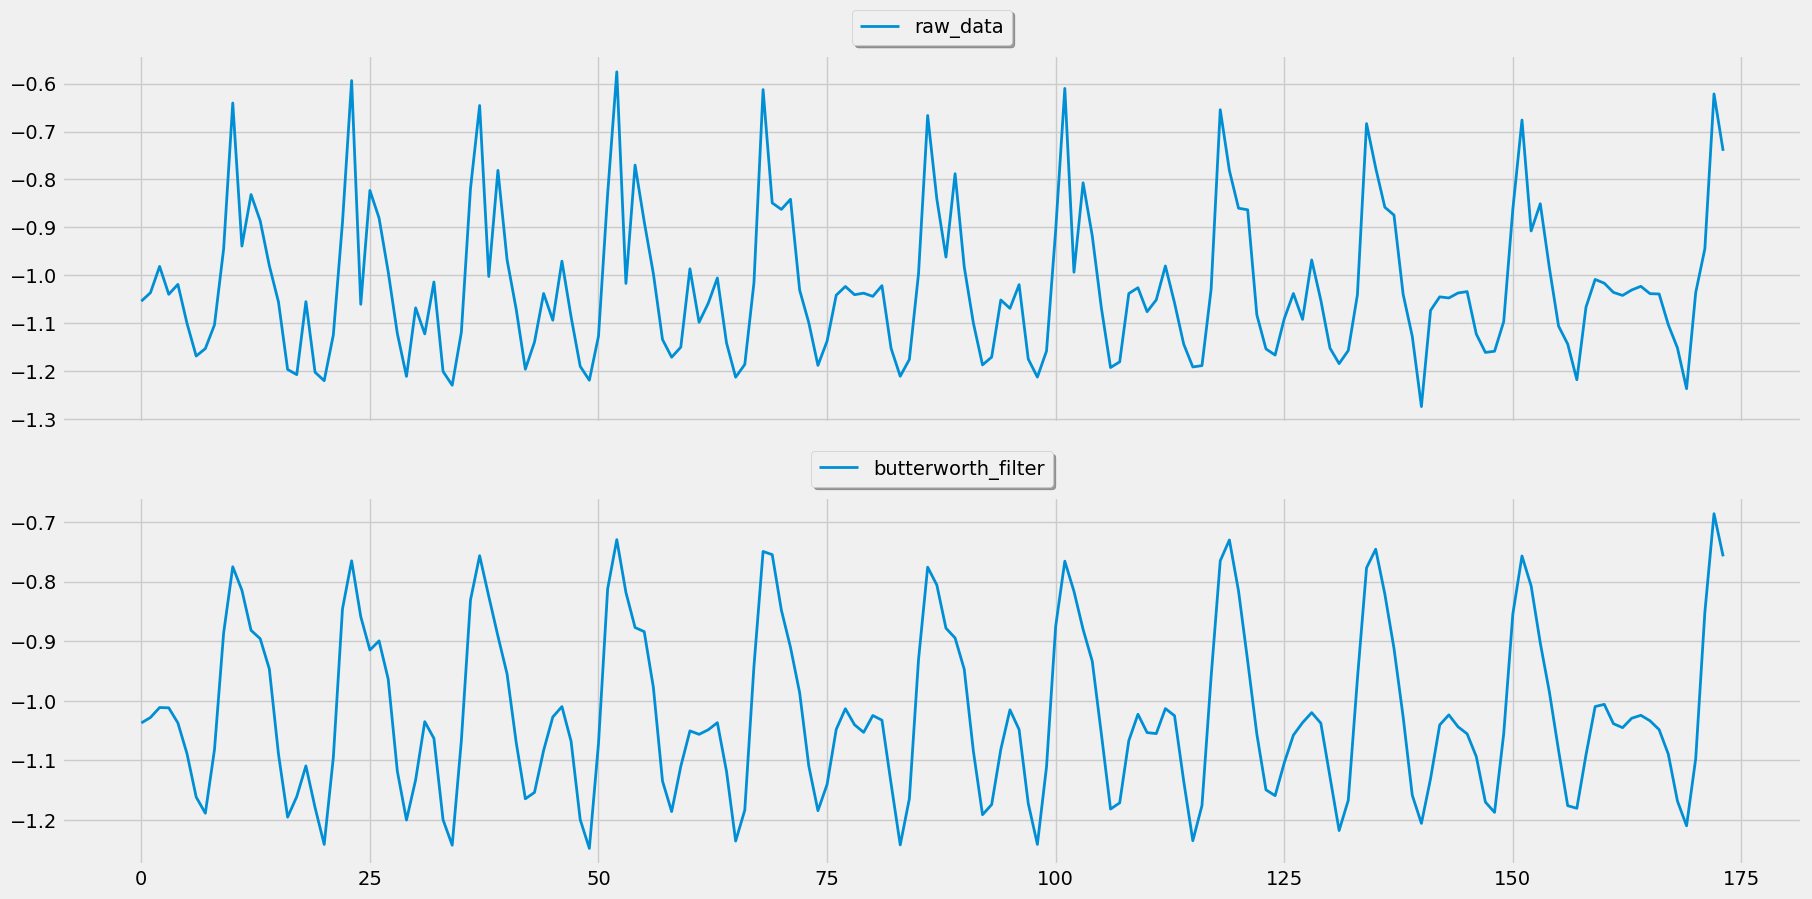

In [103]:
LowPass = LowPassFilter()
fs = 1000 / 200
cutoff = 1.3
df_lowpass = LowPass.low_pass_filter(df_lowpass,'acc_y',fs,cutoff,order= 5)

subset = df_lowpass[df_lowpass['set']==45]
print(subset['label'][0])

fig , ax = plt.subplots(nrows = 2 , sharex = True , figsize = (20,10))
ax[0].plot(subset['acc_y'].reset_index(drop = True),label= 'raw_data')
ax[1].plot(subset['acc_y_lowpass'].reset_index(drop = True),label= 'butterworth_filter')
ax[0].legend(loc = 'upper center',bbox_to_anchor = (0.5 , 1.15),fancybox = True , shadow = True)
ax[1].legend(loc = 'upper center',bbox_to_anchor = (0.5 , 1.15),fancybox = True , shadow = True)

In [104]:
for col in  predictor_columns:
  df_lowpass = LowPass.low_pass_filter(df_lowpass,col,fs,cutoff,order= 5)
  df_lowpass[col] = df_lowpass[col + '_lowpass']
  del df_lowpass[col + '_lowpass']

In [105]:
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,71,16.0
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,71,16.0
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,71,16.0
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,71,16.0
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,71,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,68,19.0
2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,68,19.0
2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,68,19.0


# Principal component analysis PCA

Text(0, 0.5, 'explained varience ')

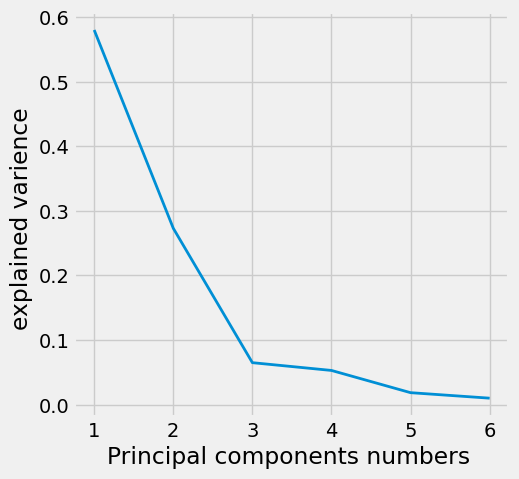

In [106]:
df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

pc_values = PCA.determine_pc_explained_variance(df_pca , predictor_columns)

plt.figure(figsize=(5,5))
plt.plot(range(1,len(predictor_columns )+1), pc_values)
plt.xlabel('Principal components numbers ')
plt.ylabel('explained varience ')

In [107]:
df_pca = PCA.apply_pca(df_pca , predictor_columns,3)

In [108]:
df_pca.head(2)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,71,16.0,-0.315889,-0.075461,0.072243
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,71,16.0,-0.314873,-0.073888,0.069825


<Axes: xlabel='epoch (ms)'>

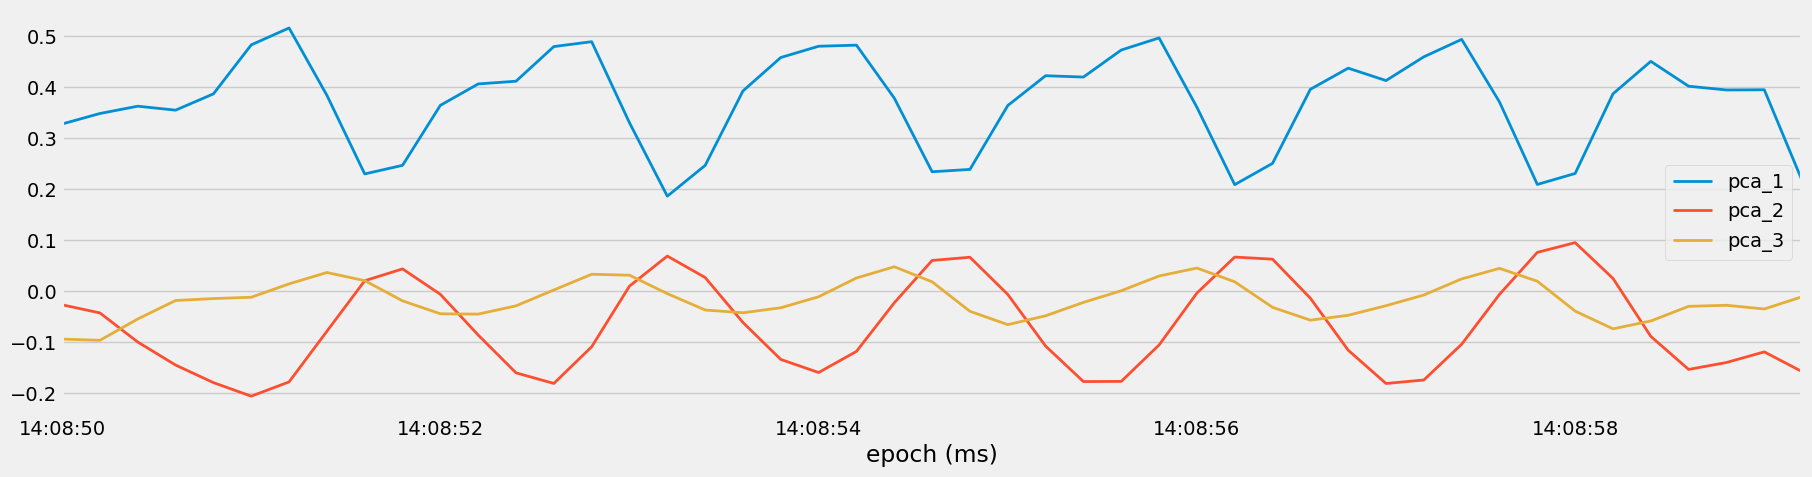

In [109]:
subset = df_pca[df_pca['set']==37]
subset[['pca_1','pca_2','pca_3']].plot()


# Sum of squares attributes

In [110]:
df_squared = df_pca.copy()

In [111]:
acc_r = df_squared['acc_x']**2  +  df_squared['acc_y']**2  + df_squared['acc_z']**2
gyr_r = df_squared['gyr_x']**2  +  df_squared['gyr_y']**2  + df_squared['gyr_z']**2
df_squared['acc_r'] = np.sqrt(acc_r)
df_squared['gyr_r'] = np.sqrt(gyr_r)

array([<Axes: xlabel='epoch (ms)'>, <Axes: xlabel='epoch (ms)'>],
      dtype=object)

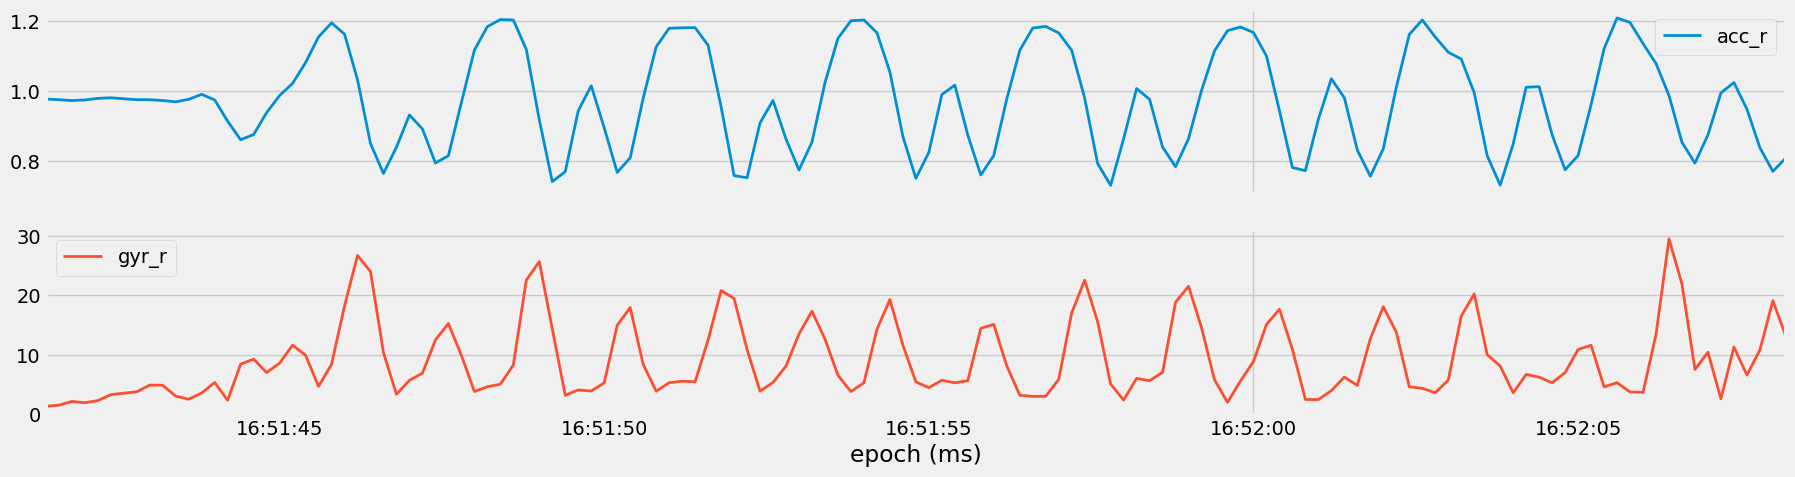

In [112]:
subset = df_squared[df_squared['set']==14]
subset[['acc_r','gyr_r']].plot(subplots = True)


# Temporal abstraction

In [113]:
df_squared

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,71,16.0,-0.315889,-0.075461,0.072243,0.979672,3.222503
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,71,16.0,-0.314873,-0.073888,0.069825,0.975474,0.600176
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,71,16.0,-0.314236,-0.080343,0.066219,0.969585,4.948974
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,71,16.0,-0.314356,-0.090852,0.061839,0.966278,5.903203
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,71,16.0,-0.313630,-0.097479,0.062974,0.964693,2.293593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,68,19.0,0.349351,-0.148450,-0.053031,0.991076,4.508719
2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,68,19.0,0.371610,-0.151455,-0.058498,1.056234,4.289212
2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,68,19.0,0.368098,-0.153153,-0.058772,1.047919,2.329568


In [114]:
df_temporal = df_squared.copy()
df_temporal.drop(columns = (['duration']),inplace = True)

In [115]:
NumAbs = NumericalAbstraction()

In [116]:
predictor_columns = predictor_columns +["acc_r","gyr_r"]

In [117]:
ws = int(1000/200)
for col in predictor_columns:
  df_temporal = NumAbs.abstract_numerical(df_temporal,[col],ws,'mean')
  df_temporal = NumAbs.abstract_numerical(df_temporal,[col],ws,'std')

In [118]:
df_temporal_list = []
for s in df_temporal['set'].unique():
  subset = df_temporal[df_temporal['set']==s].copy()
  for col in predictor_columns:
      subset = NumAbs.abstract_numerical(subset,[col],ws,'mean')
      subset = NumAbs.abstract_numerical(subset,[col],ws,'std')
  df_temporal_list.append(subset)


In [119]:
df_temporal = pd.concat(df_temporal_list)

In [120]:
df_temporal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acc_x                 9009 non-null   float64
 1   acc_y                 9009 non-null   float64
 2   acc_z                 9009 non-null   float64
 3   gyr_x                 9009 non-null   float64
 4   gyr_y                 9009 non-null   float64
 5   gyr_z                 9009 non-null   float64
 6   participant           9009 non-null   object 
 7   label                 9009 non-null   object 
 8   category              9009 non-null   object 
 9   set                   9009 non-null   int64  
 10  pca_1                 9009 non-null   float64
 11  pca_2                 9009 non-null   float64
 12  pca_3                 9009 non-null   float64
 13  acc_r                 9009 non-null   float64
 14  gyr_r                 

<Axes: xlabel='epoch (ms)'>

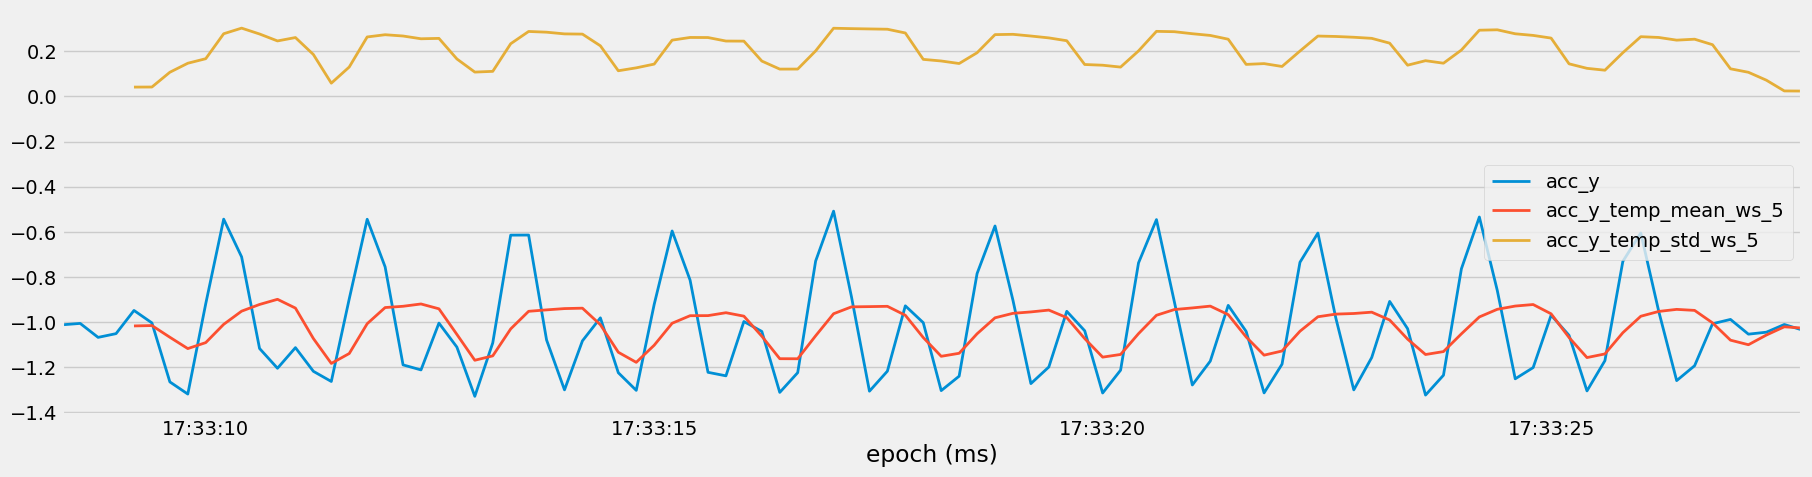

In [121]:
subset[['acc_y','acc_y_temp_mean_ws_5','acc_y_temp_std_ws_5']].plot()

<Axes: xlabel='epoch (ms)'>

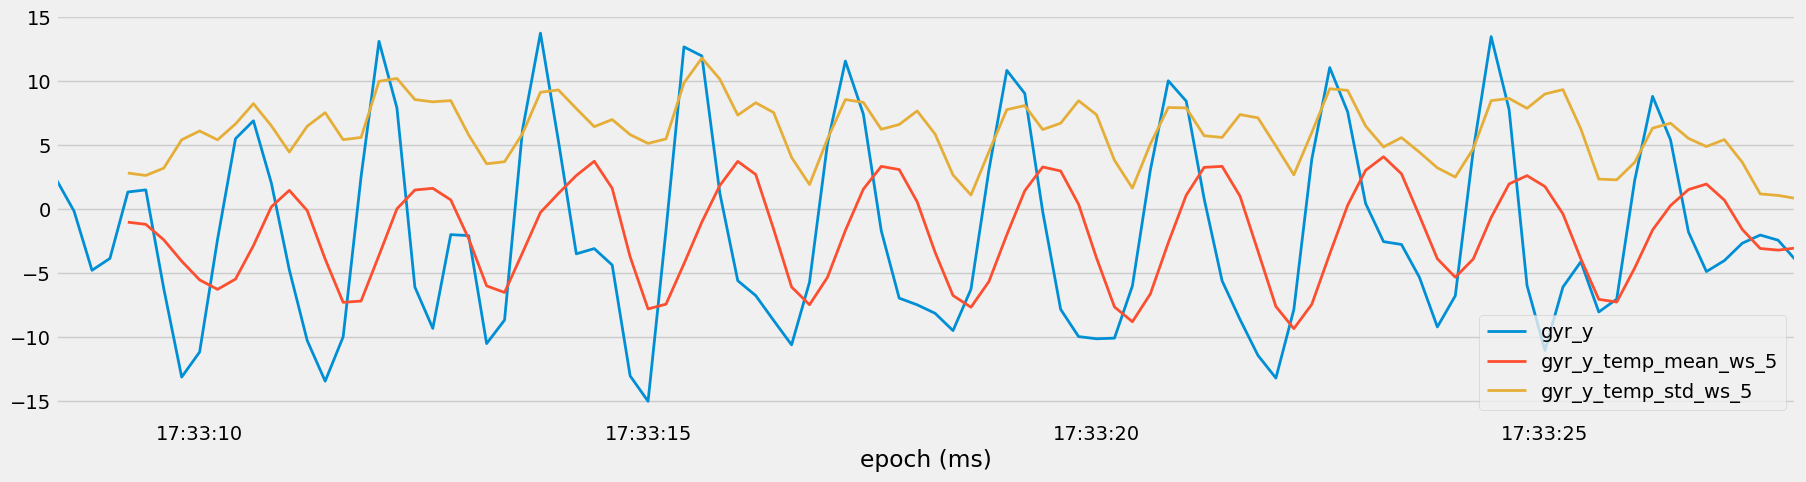

In [122]:
subset[['gyr_y','gyr_y_temp_mean_ws_5','gyr_y_temp_std_ws_5']].plot()

# Frequency features

In [123]:
df_freq = df_temporal.copy().reset_index()
FreqAbs = FourierTransformation()

In [124]:
fs = int(1000 / 200)
ws = int(2800 / 200)
df_freq  = FreqAbs.abstract_frequency(df_freq,['acc_y'],ws , fs)

In [125]:
df_freq.head()

,epoch (ms),acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,...,acc_y_freq_weighted,acc_y_pse,acc_y_freq_0.0_Hz_ws_14,acc_y_freq_0.357_Hz_ws_14,acc_y_freq_0.714_Hz_ws_14,acc_y_freq_1.071_Hz_ws_14,acc_y_freq_1.429_Hz_ws_14,acc_y_freq_1.786_Hz_ws_14,acc_y_freq_2.143_Hz_ws_14,acc_y_freq_2.5_Hz_ws_14
0,2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


visualize results

<Axes: >

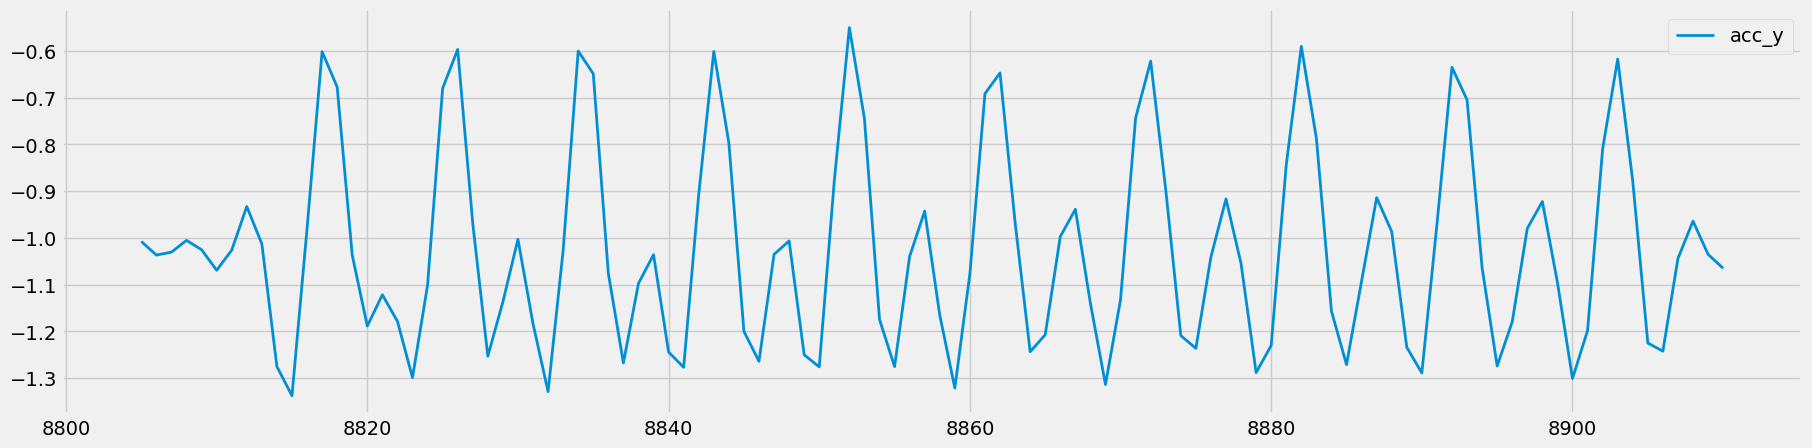

In [154]:
subset = df_freq[df_freq['set']==8]
subset[['acc_y']].plot()


<Axes: >

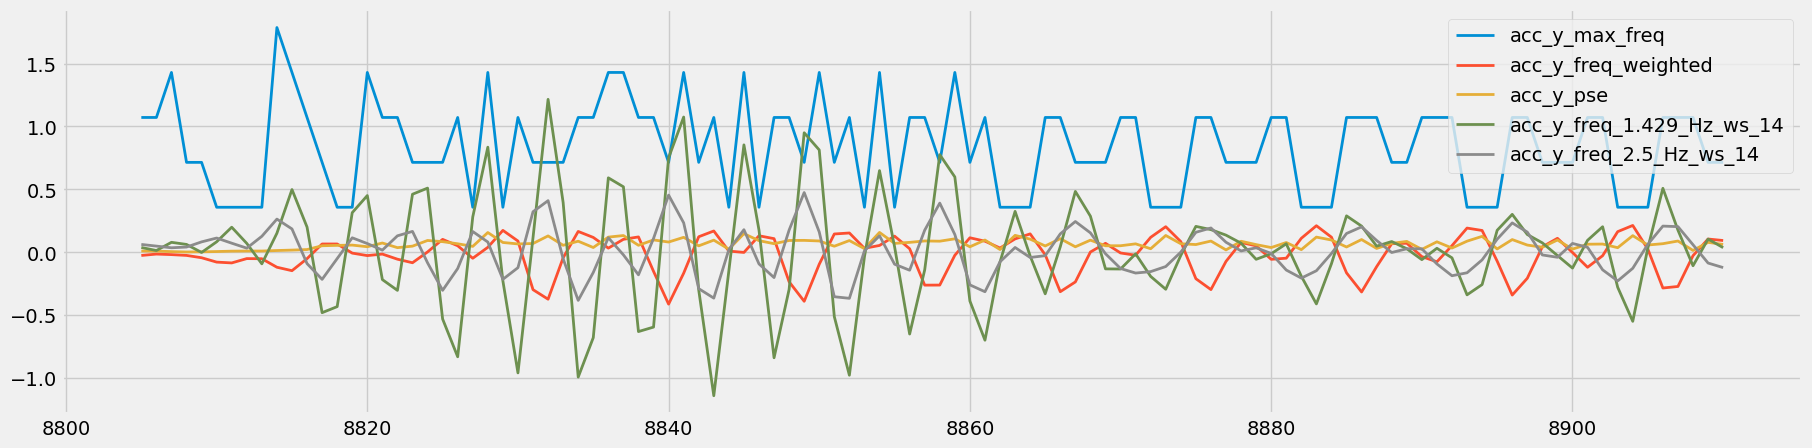

In [155]:
subset[[
    "acc_y_max_freq",
    "acc_y_freq_weighted",
    "acc_y_pse",
    "acc_y_freq_1.429_Hz_ws_14",
    "acc_y_freq_2.5_Hz_ws_14",
]].plot()

In [156]:
df_freq_list = []
for s in df_freq['set'].unique():
  print(f'Apply Fourier transformation to set  {s}')
  subset = df_freq[df_freq['set']==s].reset_index(drop=True).copy()
  subset = FreqAbs.abstract_frequency(subset,predictor_columns,ws,fs)
  df_freq_list.append(subset)


Apply Fourier transformation to set  71
Apply Fourier transformation to set  69
Apply Fourier transformation to set  39
Apply Fourier transformation to set  86
Apply Fourier transformation to set  78
Apply Fourier transformation to set  11
Apply Fourier transformation to set  74
Apply Fourier transformation to set  48
Apply Fourier transformation to set  13
Apply Fourier transformation to set  33
Apply Fourier transformation to set  81
Apply Fourier transformation to set  53
Apply Fourier transformation to set  28
Apply Fourier transformation to set  77
Apply Fourier transformation to set  23
Apply Fourier transformation to set  16
Apply Fourier transformation to set  64
Apply Fourier transformation to set  59
Apply Fourier transformation to set  56
Apply Fourier transformation to set  88
Apply Fourier transformation to set  60
Apply Fourier transformation to set  3
Apply Fourier transformation to set  12
Apply Fourier transformation to set  21
Apply Fourier transformation to set  72
A

In [159]:
df_freq = pd.concat(df_freq_list).set_index('epoch (ms)', drop = True)
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,68,...,-0.255402,0.238607,319.521621,-34.907878,31.861740,9.784884,1.149502,-51.406834,-1.543486,0.948401
2019-01-20 17:33:27.200,-0.041403,-1.053448,-0.064530,-2.967835,-2.660315,1.584934,E,row,medium,68,...,0.536997,0.660463,308.391215,-44.886326,66.358365,78.568468,-20.114545,64.769560,14.905502,8.625034
2019-01-20 17:33:27.400,-0.048048,-1.044737,-0.065951,-0.043109,-2.022091,1.155930,E,row,medium,68,...,0.633179,0.577277,267.731227,-73.117861,40.866650,37.338879,18.436116,18.097675,21.450904,33.080361


# Dealing with overlapping windows

In [161]:
df_freq = df_freq.dropna()
df_freq = df_freq.iloc[::2]
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:08.000,-0.172350,0.909033,-0.168556,-27.895242,-10.831760,26.285743,B,bench,heavy,71,...,-1.099263,0.404506,241.915837,-32.414519,17.800054,-7.090627,-23.559585,15.300362,-56.937517,-9.887314
2019-01-11 15:08:08.400,-0.024777,0.860474,-0.059254,-2.040040,-1.316930,1.986210,B,bench,heavy,71,...,-0.182028,0.376805,266.641927,-45.027971,-65.743054,-12.016695,8.716330,14.278175,5.797033,-2.207473
2019-01-11 15:08:08.800,-0.063378,0.997048,-0.033869,1.164754,-1.844231,-1.240332,B,bench,heavy,71,...,-0.547866,0.508919,262.078311,-56.234625,-30.091473,3.458370,-13.917311,-48.217504,42.767778,-11.602442
2019-01-11 15:08:09.200,-0.044993,0.971809,-0.038011,2.469483,-3.482648,3.563210,B,bench,heavy,71,...,0.447313,0.492961,256.245567,-31.989318,69.348370,3.624009,17.424045,36.328368,26.990522,-9.999852
2019-01-11 15:08:09.600,-0.046925,0.911220,-0.056463,8.471911,4.745072,-8.708681,B,bench,heavy,71,...,-0.466787,0.363189,214.663711,-12.227055,13.687545,10.833066,6.326124,25.453064,-35.551747,-33.538487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:26.200,0.063910,-0.952114,0.107673,-38.792016,8.810964,14.997831,E,row,medium,68,...,-1.344815,0.350704,368.429928,29.216316,-57.045603,10.239165,-47.609218,-37.827325,-17.620149,-36.551825
2019-01-20 17:33:26.600,-0.024266,-1.193314,-0.109309,-2.783290,-1.783932,6.232364,E,row,medium,68,...,0.463020,0.324461,379.719977,39.879652,-21.517667,-13.542762,27.460451,82.477003,22.715838,9.757813
2019-01-20 17:33:27.000,-0.043276,-0.988153,-0.062545,2.032956,-4.019557,0.196986,E,row,medium,68,...,-0.255402,0.238607,319.521621,-34.907878,31.861740,9.784884,1.149502,-51.406834,-1.543486,0.948401


# Clustering

In [165]:
df_cluster= df_freq.copy()
cluster_columns = ['acc_x','acc_y','acc_z']
k_values = range(2,10)
inertias = []

for k in k_values :
  subset = df_cluster[cluster_columns]
  Kmeans = KMeans(n_clusters = k , n_init = 20, random_state = 0)
  cluster_labels = Kmeans.fit_predict(subset)
  inertias.append(Kmeans.inertia_)

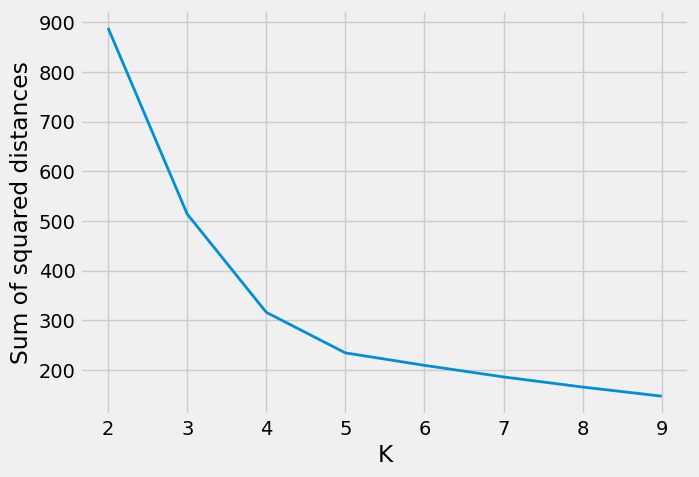

In [168]:
plt.figure(figsize = (7,5))
plt.plot(k_values, inertias)
plt.xlabel("K")
plt.ylabel("Sum of squared distances")
plt.show()

In [171]:
subset = df_cluster[cluster_columns]
Kmeans = KMeans(n_clusters = 5 , n_init = 20, random_state = 0) # no of clusters are set to 5
df_cluster['cluster'] = Kmeans.fit_predict(subset)

Plot Clusters

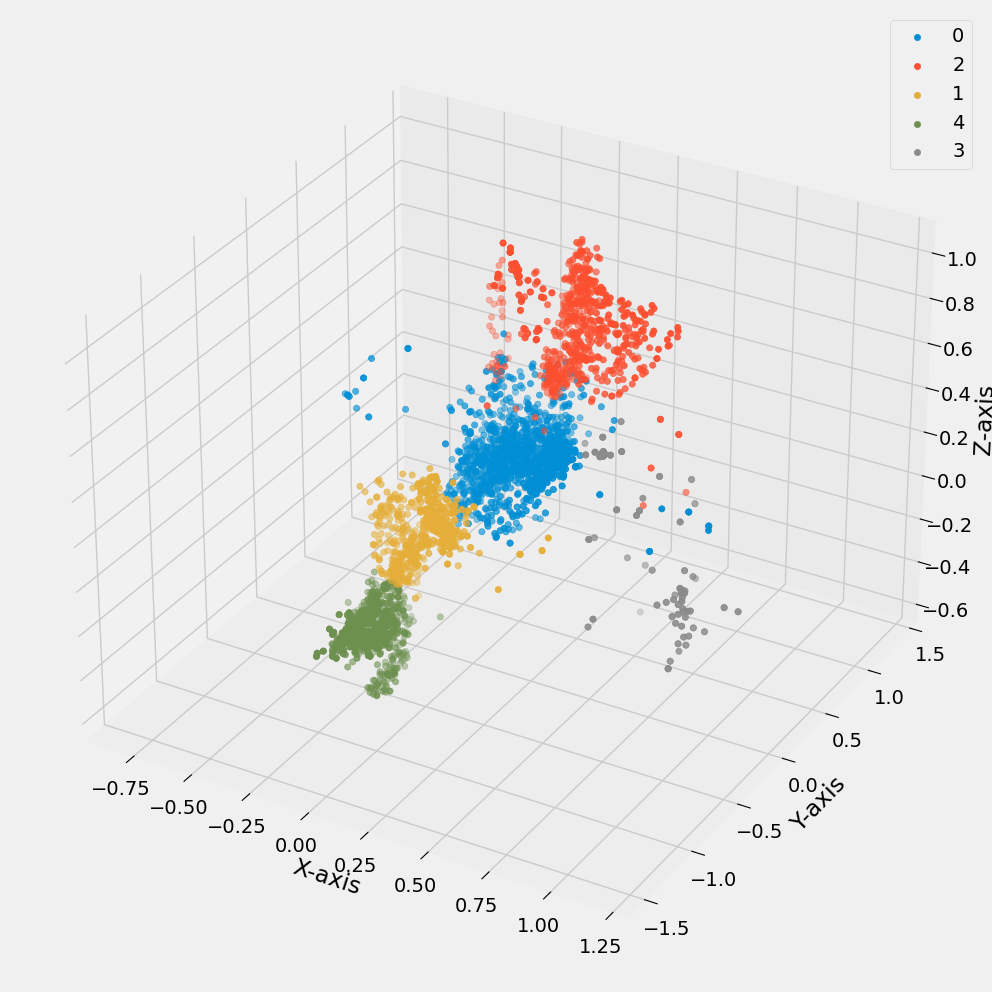

In [173]:
fig  = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection = '3d')
for c in df_cluster['cluster'].unique():
  subplot = df_cluster[df_cluster['cluster']==c]
  ax.scatter(subplot['acc_x'] , subplot['acc_y'] , subplot['acc_z'] , label = c)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

plot accelerometer data to compare

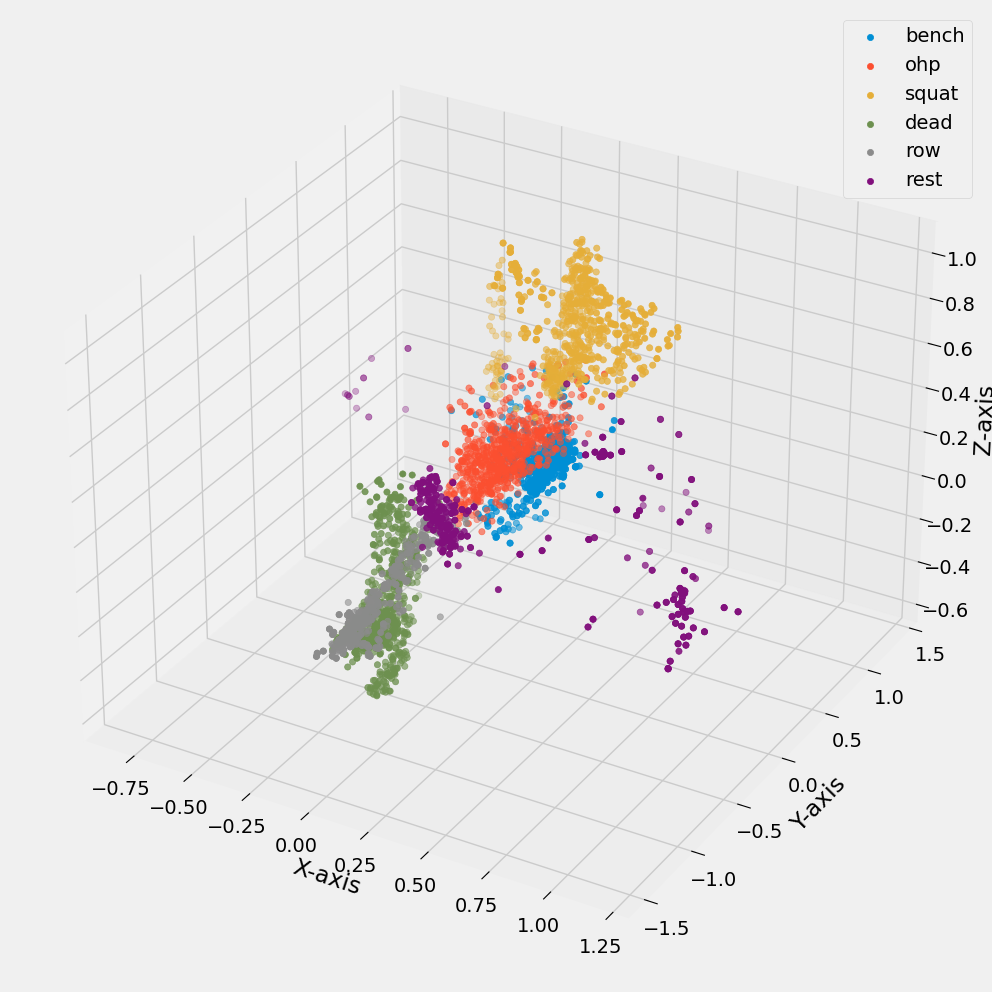

In [174]:
fig  = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection = '3d')
for l in df_cluster['label'].unique():
  subplot = df_cluster[df_cluster['label']==l]
  ax.scatter(subplot['acc_x'] , subplot['acc_y'] , subplot['acc_z'] , label = l)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

# Export dataset

In [176]:
df_cluster.to_pickle('/content/drive/MyDrive/FitnessTracker/FitnessTracker/data-science-template-main/data/interim/03_data_features.pkl')